In [1]:
import sys # for gioia to load aiohttp - delete before finalizing
sys.path.append('/Users/maggiori/anaconda/envs/py35/lib/python3.5/site-packages')

In [2]:
# to import modules locally without having installed the entire package
# http://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [3]:
import subprocess
import numpy as np
from scipy.stats import norm
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

# Stock Market Similarity Searches

We have included daily closing prices for 379 stocks on the S&P 500. The switch below determines whether to load daily prices or daily returns.

In [87]:
# True: daily prices
# False: daily returns
data_prices = True

if data_prices:
    file_name = 'data/prices.json'
    title = 'Daily Stock Price'
else:
    file_name = 'data/returns.json'
    title = 'Daily Stock Return'

### Initialization

Load the database server.

In [88]:
# when running from the terminal
# python go_server.py

# here we load the server as a subprocess for demonstration purposes
server = subprocess.Popen(['python', '../go_server.py'])

Load the database webserver.

In [89]:
# when running from the terminal
# python go_webserver.py

# here we load the server as a subprocess for demonstration purposes
webserver = subprocess.Popen(['python', '../go_webserver.py'])

Import the web interface and initialize it.

In [90]:
from webserver import *

In [91]:
web_interface = WebInterface()

Import the `timeseries` package and load the stock data.

In [92]:
from timeseries import *

In [93]:
with open(file_name) as f:    
    stock_data = json.load(f)
    
# keep track of the stock tickers
stocks = sorted(list(stock_data.keys()))
num_stocks = len(stocks)

# check the number of market days in the year
num_days = len(stock_data[stocks[0]])

# randomly pick stocks to exclude - we'll use these for similarity searches
stocks_exclude = np.random.choice(stocks, size=29, replace=False)
stocks_include = [s for s in stocks if s not in stocks_exclude]

Insert the time series data into the database, remembering to exclude the stocks we excluded.

In [94]:
for stock in stocks_include:
    web_interface.insert_ts(pk=stock, ts=TimeSeries(range(num_days), stock_data[stock]))

Look at the first 10 stocks, to check that it has been loaded correctly.

In [95]:
# let's look at the first 10 stocks
results = web_interface.select(fields=[], additional={'sort_by': '+pk', 'limit': 10})
results

OrderedDict([('A', OrderedDict([('pk', 'A')])),
             ('AA', OrderedDict([('pk', 'AA')])),
             ('ABC', OrderedDict([('pk', 'ABC')])),
             ('ABT', OrderedDict([('pk', 'ABT')])),
             ('ADM', OrderedDict([('pk', 'ADM')])),
             ('AEE', OrderedDict([('pk', 'AEE')])),
             ('AEP', OrderedDict([('pk', 'AEP')])),
             ('AET', OrderedDict([('pk', 'AET')])),
             ('AFL', OrderedDict([('pk', 'AFL')])),
             ('AGN', OrderedDict([('pk', 'AGN')]))])

### Vantage Point Search

Pick 30 of the 379 stocks randomly as vantage points.

In [96]:
num_vps = 30

random_vps = np.random.choice(range(num_stocks), size=num_vps, replace=False)
vpkeys = [stocks[s] for s in random_vps if stocks[s] in stocks_include]

Mark the stocks as vantage points.

In [98]:
for vp in vpkeys:
    web_interface.insert_vp(vp)

Pick a random stock to carry out a similarity search.

In [99]:
stock = np.random.choice(stocks_exclude)
stock

'ADI'

Run the vantage point similarity search.

In [100]:
result = web_interface.vp_similarity_search(TimeSeries(range(num_days), stock_data[stock]), 1)
result

OrderedDict([('TXN', 0.8102205750900034)])

Visualize the results, to check how similar the two time series are.

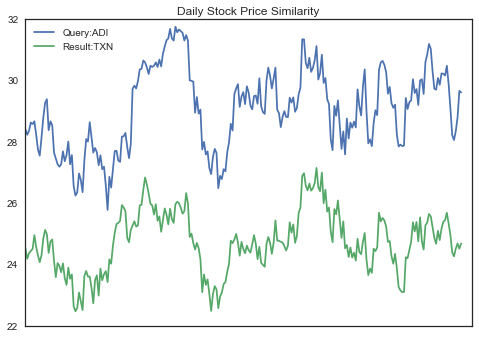

In [101]:
# visualize the results
plt.plot(stock_data[stock], label='Query:' + stock)
plt.plot(stock_data[list(result)[0]], label='Result:' + list(result)[0])
plt.xticks([])
plt.legend(loc='best')
plt.title(title + ' Similarity')
plt.show()

### iSAX Tree Search

Pick a random stock to carry out a similarity search.

In [102]:
stock = np.random.choice(stocks_exclude)
stock

'HCP'

Run the iSAX similarity search.

In [103]:
result = web_interface.isax_similarity_search(TimeSeries(range(num_days), stock_data[stock]))
result

OrderedDict([('EMC', 207.25144114396406)])

Visualize the results, to check how similar the two time series are.

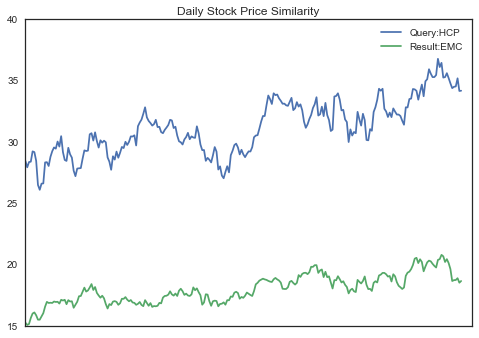

In [104]:
# visualize the results
plt.plot(stock_data[stock], label='Query:' + stock)
plt.plot(stock_data[list(result)[0]], label='Result:' + list(result)[0])
plt.xticks([])
plt.legend(loc='best')
plt.title(title + ' Similarity')
plt.show()

### Comparing Similarity Searches

Pick a random stock to carry out a similarity search.

In [105]:
stock = np.random.choice(stocks_exclude)
stock

'HCP'

In [106]:
result_vp = web_interface.vp_similarity_search(TimeSeries(range(num_days), stock_data[stock]), 1)
result_isax = web_interface.isax_similarity_search(TimeSeries(range(num_days), stock_data[stock]))
result_vp, result_isax

(OrderedDict([('SO', 0.6326195582688068)]),
 OrderedDict([('EMC', 207.25144114396406)]))

Visualize the results, to check how similar the two results are.

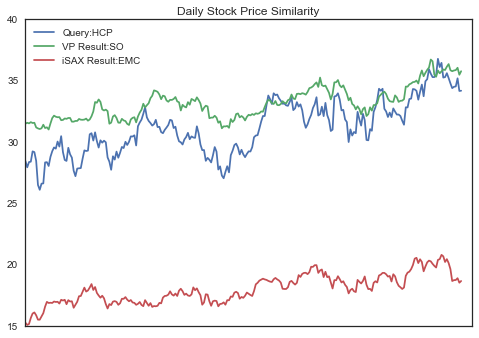

In [107]:
# visualize the results
plt.plot(stock_data[stock], label='Query:' + stock)
plt.plot(stock_data[list(result_vp)[0]], label='VP Result:' + list(result_vp)[0])
try:
    plt.plot(stock_data[list(result_isax)[0]], label='iSAX Result:' + list(result_isax)[0])
except KeyError:
    pass
plt.xticks([])
plt.legend(loc='best')
plt.title(title + ' Similarity')
plt.show()

### iSAX Tree Representation

In [108]:
print(web_interface.isax_tree())

root
--->['11', '10', '00', '10']: 0 []
------>['110', '100', '000', '100']: 4 ['A', 'JCI', 'JWN', 'PKI']
------>['110', '101', '000', '100']: 2 ['CCL', 'FO']
------>['110', '101', '000', '101']: 1 ['LMT']
------>['110', '100', '001', '101']: 1 ['TXT']
------>['110', '100', '000', '101']: 1 ['USB']
--->['01', '00', '01', '11']: 0 []
------>['011', '001', '010', '111']: 5 ['AA', 'AKS', 'CF', 'CSC', 'KG']
------>['010', '001', '011', '111']: 2 ['BAX', 'NOV']
------>['011', '001', '011', '110']: 1 ['COG']
------>['011', '000', '011', '111']: 1 ['PFE']
--->['11', '10', '01', '00']: 0 []
------>['111', '100', '010', '001']: 3 ['ABC', 'EOG', 'WEC']
------>['111', '101', '010', '000']: 2 ['AVB', 'TIE']
------>['110', '101', '011', '000']: 2 ['AZO', 'NEM']
------>['111', '101', '010', '001']: 0 []
--------->['1110', '1010', '0100', '0010']: 0 []
------------>['11100', '10101', '01001', '00100']: 1 ['BF.B']
------------>['11100', '10100', '01000', '00101']: 2 ['HRL', 'MCD']
------------>['11100

### Termination

Remember to terminate any outstanding processes.

In [109]:
server.terminate()
webserver.terminate()
web_interface = None